# Noisy QCNN mnist MNIST

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import pennylane as qml
import embedding
import data

dev = qml.device('default.qubit', wires=4)

In [2]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

# NQE Optimization

In [3]:
@qml.qnode(dev, interface="torch")
def Four_circuit2(inputs): 
    embedding.Four_QuantumEmbedding2(inputs[0:8])
    embedding.Four_QuantumEmbedding2_inverse(inputs[8:16])
    return qml.probs(wires=range(4))

class PCA_NQE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Four_circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 8)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]


class NQE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Four_circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc1 = torch.nn.Linear(7 * 7, 32, bias=True)
        self.fc2 = torch.nn.Linear(32, 8, bias=True)
        
    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc1(x2)
        x2 = self.fc2(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

In [4]:
def new_data(batch_size, X, Y, feature_reduction):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new, X2_new, Y_new

def train_models(model_name, X_train, Y_train, feature_reduction):
    if model_name == 'PCA-NQE':
        model = PCA_NQE()
    elif model_name == 'NQE':
        model = NQE()

    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(1001):

        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train, feature_reduction)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 50 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
            PATH = f'{model_name}{it}.pt'
            torch.save(model.state_dict(), PATH)


In [5]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
train_models('PCA-NQE', X_train, Y_train, feature_reduction)

/tmp/ipykernel_141458/203686661.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iterations: 0 Loss: 0.11589503288269043
Iterations: 50 Loss: 0.1189134418964386
Iterations: 100 Loss: 0.0358554907143116
Iterations: 150 Loss: 0.021144839003682137
Iterations: 200 Loss: 0.04969969391822815
Iterations: 250 Loss: 0.0420103520154953
Iterations: 300 Loss: 0.050136275589466095
Iterations: 350 Loss: 0.005058660637587309
Iterations: 400 Loss: 0.058206282556056976
Iterations: 450 Loss: 0.01435084268450737
Iterations: 500 Loss: 0.0010045686503872275
Iterations: 550 Loss: 0.003550964640453458
Iterations: 600 Loss: 0.005084353499114513
Iterations: 650 Loss: 0.004784946795552969
Iterations: 700 Loss: 0.030549034476280212
Iterations: 750 Loss: 0.0234286617487669
Iterations: 800 Loss: 0.08569028973579407
Iterations: 850 Loss: 0.0035394844599068165
Iterations: 900 Loss: 0.07799077033996582
Iterations: 950 Loss: 0.013234508223831654
Iterations: 1000 Loss: 0.004361440427601337


In [17]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
train_models('NQE', X_train, Y_train, feature_reduction)

Iterations: 0 Loss: 0.47596272826194763
Iterations: 50 Loss: 0.42184191942214966
Iterations: 100 Loss: 0.036236539483070374
Iterations: 150 Loss: 0.03684104606509209
Iterations: 200 Loss: 0.009287651628255844
Iterations: 250 Loss: 0.01494860090315342
Iterations: 300 Loss: 0.021638160571455956
Iterations: 350 Loss: 0.013957703486084938
Iterations: 400 Loss: 0.008100656792521477
Iterations: 450 Loss: 0.01200499664992094
Iterations: 500 Loss: 0.005487876012921333
Iterations: 550 Loss: 0.026784874498844147
Iterations: 600 Loss: 0.021990323439240456
Iterations: 650 Loss: 0.004274984821677208
Iterations: 700 Loss: 0.0025940164923667908
Iterations: 750 Loss: 0.011126544326543808
Iterations: 800 Loss: 0.005009116604924202
Iterations: 850 Loss: 0.01734338514506817
Iterations: 900 Loss: 0.020266540348529816
Iterations: 950 Loss: 0.005217379424721003
Iterations: 1000 Loss: 0.013666364364326


# QCNN Training

In [29]:
batch_size = 128
steps = 1000
ansatz = "SU4"
learning_rate = 0.01

In [4]:

class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 8)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc1 = torch.nn.Linear(7 * 7, 32, bias=True)
        self.fc2 = torch.nn.Linear(32, 8, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc1(x)
        x = self.fc2(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

In [5]:
def statepreparation(x, Trained):
    if Trained == False:
        embedding.Four_QuantumEmbedding1(x)
    elif Trained == 'PCA-NQE':
        model2.load_state_dict(torch.load('PCA-NQE1000.pt'))
        x = model2(torch.tensor(x))
        embedding.Four_QuantumEmbedding2(x)
    elif Trained == 'NQE':
        model3.load_state_dict(torch.load('NQE1000.pt'))
        x = model3(torch.tensor(x))
        embedding.Four_QuantumEmbedding2(x[0])


@qml.qnode(dev)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    embedding.QCNN_four(params, ansatz)
    return qml.expval(qml.PauliZ(2))


def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)


def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, Trained):

    if ansatz == 'SU4':
        num_weights = 30
    elif ansatz == 'TTN':
        num_weights = 4

    weights = np.random.random(num_weights, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 200 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [32]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
#X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [33]:
Loss_histories_not_trained, weights_not_trained, Loss_histories_Model2_Fidelity, weights_Model2_Fidelity = [], [], [], []
for i in range(5):
    #loss_not_trained, weight_not_trained = circuit_training(X_train, Y_train, False)
    loss_Model2_Fidelity, weight_Model2_Fidelity = circuit_training(X_train, Y_train, 'PCA-NQE')

    #Loss_histories_not_trained.append(loss_not_trained)
    Loss_histories_Model2_Fidelity.append(loss_Model2_Fidelity)

    #weights_not_trained.append(weight_not_trained)
    weights_Model2_Fidelity.append(weight_Model2_Fidelity)

    
f = open('weights and losses.txt', 'a')
for i in range(5):
    f.write(f'Loss History with PCA-NQE {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model2_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights with PCA-NQE {i + 1}:')
    f.write('\n')
    f.write(str(weights_Model2_Fidelity[i]))
f.close()

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.4785889708045189
iteration:  200  cost:  0.41099285716385153
iteration:  400  cost:  0.4460870119981242
iteration:  600  cost:  0.3814255495897814
iteration:  800  cost:  0.4185542042253466
iteration:  0  cost:  0.48433687478954734
iteration:  200  cost:  0.2417825129204142
iteration:  400  cost:  0.1576763269583487
iteration:  600  cost:  0.1640954628810935
iteration:  800  cost:  0.1553021861854564
iteration:  0  cost:  0.522019252271665
iteration:  200  cost:  0.45116785943309357
iteration:  400  cost:  0.4192796404449914
iteration:  600  cost:  0.40482246429497964
iteration:  800  cost:  0.3681962839366711
iteration:  0  cost:  0.45251859723486254
iteration:  200  cost:  0.1662378790616781
iteration:  400  cost:  0.14071523238580452
iteration:  600  cost:  0.146707212374833
iteration:  800  cost:  0.13776377061925962
iteration:  0  cost:  0.5005017687957075
iteration:  200  cost:  0.45395337688233783
iteration:  400  cost:  0.4007304387214492
iteration:  600

In [34]:
feature_reduction = False
classes=[0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2).detach().numpy(), X_test.permute(0, 3, 1, 2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [35]:
Loss_histories_Model3_Fidelity, weights_Model3_Fidelity = [], []
for i in range(5):

    loss_Model3_Fidelity, weight_Model3_Fidelity = circuit_training(X_train, Y_train, 'NQE')

    Loss_histories_Model3_Fidelity.append(loss_Model3_Fidelity)
    weights_Model3_Fidelity.append(weight_Model3_Fidelity)

f = open('weights and losses.txt', 'a')
for i in range(5):
    f.write(f'Loss History with NQE {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model3_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights with NQE{i + 1}:')
    f.write('\n')
    f.write(str(weights_Model3_Fidelity[i]))
f.close()

iteration:  0  cost:  0.5573082326292158
iteration:  200  cost:  0.14188382911216832
iteration:  400  cost:  0.1411504170795876
iteration:  600  cost:  0.12774787642855667
iteration:  800  cost:  0.1318853063651676
iteration:  0  cost:  0.5921305755361477
iteration:  200  cost:  0.12493944758938341
iteration:  400  cost:  0.12007743658654084
iteration:  600  cost:  0.11003034340621773
iteration:  800  cost:  0.09895836265563479
iteration:  0  cost:  0.5060882385597409
iteration:  200  cost:  0.09619537428257868
iteration:  400  cost:  0.08860398010571104
iteration:  600  cost:  0.10022193237200457
iteration:  800  cost:  0.09275222937163419
iteration:  0  cost:  0.3198827390729302
iteration:  200  cost:  0.11922623302402624
iteration:  400  cost:  0.09562377933483145
iteration:  600  cost:  0.10578603800326013
iteration:  800  cost:  0.106533137408736
iteration:  0  cost:  0.4455274148756447
iteration:  200  cost:  0.15263951352410735
iteration:  400  cost:  0.10496665155028197
iterati

# Trace Distance History

In [5]:
@qml.qnode(dev, interface="torch")
def Circuit_Distance1(inputs): 
    embedding.Four_QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(4))

@qml.qnode(dev, interface="torch")
def Circuit_Distance2(inputs): 
    embedding.Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))


class Distances1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Circuit_Distance1, weight_shapes={})
   
    def forward(self, x1, x0):
        rhos1 = self.qlayer1(x1)
        rhos0 = self.qlayer1(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
    
class Distances2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Circuit_Distance2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 8)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2(x1)
        rhos0 = self.qlayer2(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Circuit_Distance2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc1 = torch.nn.Linear(7 * 7, 32, bias=True)
        self.fc2 = torch.nn.Linear(32, 8, bias=True)
    
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc1(x1)
        x1 = self.fc2(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc1(x0)
        x0 = self.fc2(x0)

        rhos1 = self.qlayer3(x1)
        rhos0 = self.qlayer3(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


def D(PATH, Model, X1, X0):
    if Model == 'Model2':
        Distance = Distances2()
    elif Model == 'Model3':
        Distance = Distances3()
    
    Distance.load_state_dict(torch.load(PATH))
    return Distance(X1, X0)

Model1

In [9]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

In [14]:
Distance = Distances1()
Model1_Train_Distance = Distance(X0_train, X1_train)
print(Model1_Train_Distance)

KeyboardInterrupt: 

Model2

In [ ]:
print(D(PATH='PCA-NQE300.pt', Model='Model2', X1=X1_train, X0=X0_train))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (188776x28 and 4x12)

Model3

In [ ]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)

In [ ]:
print(D(PATH='NQE300.pt', Model='Model3', X1=X1_train, X0=X0_train))

tensor(0.9257, grad_fn=<MulBackward0>)


# Part 4: Result 

In [2]:
def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_histories = data_read("Loss History.txt").reshape(3, 5000)
Loss_histories_not_trained = Loss_histories[0].reshape(5,1000)
Loss_histories_Model2 = Loss_histories[1].reshape(5,1000)
Loss_histories_Model3 = Loss_histories[2].reshape(5,1000)


Weights = data_read("Weights.txt").reshape(3, 5 * 30)
weights_not_trained = Weights[0].reshape(5, 30)
weights_Model2 = Weights[1].reshape(5, 30)
weights_Model3 = Weights[2].reshape(5, 30)


LH0_mean, LH0_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
LH2_mean, LH2_std = Loss_histories_Model2.mean(axis=0), Loss_histories_Model2.std(axis=0)
LH3_mean, LH3_std = Loss_histories_Model3.mean(axis=0), Loss_histories_Model3.std(axis=0)

In [3]:
LB_without_NQE = 0.5 * (1 - 0.2459)
LB_with_PCA_NQE = 0.5 * (1 - 0.7380209)
LB_with_NQE = 0.5 * (1 - 0.8239291)

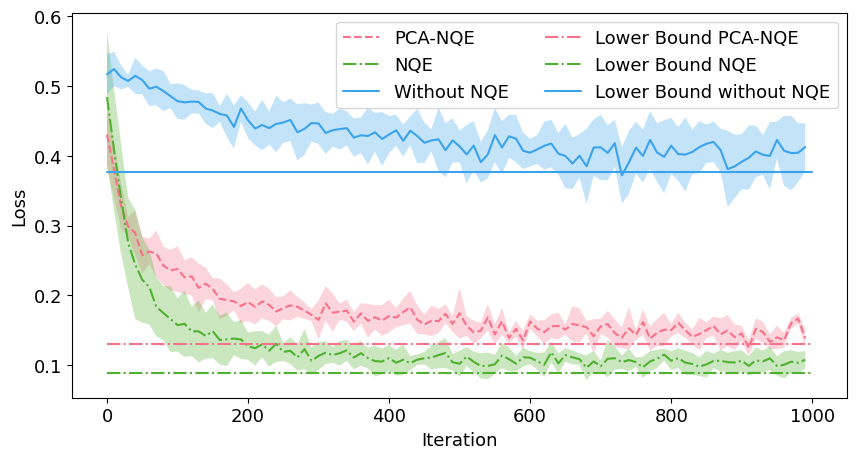

In [4]:
import seaborn as sns
n = 10
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):    
    ax.plot(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n], label="PCA-NQE", linestyle='dashed', c=clrs[0])
    ax.fill_between(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n]-LH2_std[::n], LH2_mean[::n]+LH2_std[::n], alpha=0.3,facecolor=clrs[0])

    ax.plot(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n], label="NQE", linestyle='dashdot', c=clrs[1])
    ax.fill_between(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n]-LH3_std[::n], LH3_mean[::n]+LH3_std[::n], alpha=0.3,facecolor=clrs[1])

    ax.plot(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n], label="Without NQE", linestyle='solid', c=clrs[2])
    ax.fill_between(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n]-LH0_std[::n], LH0_mean[::n]+LH0_std[::n], alpha=0.3,facecolor=clrs[2])


   
    ax.plot(range(1000), np.ones(1000) * LB_with_PCA_NQE, linestyle='dashdot', linewidth=1.5, label="Lower Bound PCA-NQE", c=clrs[0])
    ax.plot(range(1000), np.ones(1000) * LB_with_NQE, linestyle='dashdot', linewidth=1.5, label="Lower Bound NQE", c=clrs[1])
    ax.plot(range(1000), np.ones(1000) * LB_without_NQE, linestyle='solid', linewidth=1.5, label="Lower Bound without NQE", c=clrs[2])


ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
#ax.set_title("Noiseless QCNN Loss History")
ax.legend(fontsize=13, ncol=2)
plt.savefig("Loss History.pdf")


Calculate the classification accuracies for Model1,2

In [52]:
feature_reduction = 'PCA4'
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [53]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_not_trained, accuracies_Model2_Fidelity = [], []

for i in range(5):
    prediction_not_trained = [QCNN_classifier(weights_not_trained[i], x, Trained=False) for x in X_test]
    prediction_Model2_Fidelity = [QCNN_classifier(weights_Model2_Fidelity[i], x, Trained='PCA-NQE') for x in X_test]
    
    accuracy_not_trained = accuracy_test(prediction_not_trained, Y_test)
    accuracy_Model2_Fidelity = accuracy_test(prediction_Model2_Fidelity, Y_test)

    accuracies_not_trained.append(accuracy_not_trained)
    accuracies_Model2_Fidelity.append(accuracy_Model2_Fidelity)

accuracies_not_trained = np.array(accuracies_not_trained)
accuracies_Model2_Fidelity = np.array(accuracies_Model2_Fidelity)

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/tmp/ipykernel_268848/1513383349.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model2(torch.tensor(x))


In [54]:
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [55]:
accuracies_Model3_Fidelity = []

for i in range(5):
    prediction_Model3_Fidelity = [QCNN_classifier(weights_Model3_Fidelity[i], x, Trained='NQE') for x in X_test]
    accuracy_Model3_Fidelity = accuracy_test(prediction_Model3_Fidelity, Y_test)
    accuracies_Model3_Fidelity.append(accuracy_Model3_Fidelity)

accuracies_Model3_Fidelity =np.array(accuracies_Model3_Fidelity)

/tmp/ipykernel_268848/1513383349.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model3(torch.tensor(x))


In [56]:

print("QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" Accuracy without NQE: {accuracies_not_trained.mean()} ± {accuracies_not_trained.std()}")
print(f" Accuracy with PCA-NQE: {accuracies_Model2_Fidelity.mean()} ± {accuracies_Model2_Fidelity.std()}")
print(f" Accuracy with NQE: {accuracies_Model3_Fidelity.mean()} ± {accuracies_Model3_Fidelity.std()}")


QCNN classification accuracies:

-------------------------------------

 Accuracy without NQE: 0.5522 ± 0.012180311982868095
 Accuracy with PCA-NQE: 0.8768 ± 0.0019131126469708892
 Accuracy with NQE: 0.9611000000000001 ± 0.0030886890422960928
